## Step 1: Climate Analysis and Exploration

### Setup Dependencies to be used for Project

In [49]:
# Dependencies and Setup

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
from scipy.stats import ttest_ind

###  Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import Table, Column, Integer, String, Float

In [3]:
# Connect to database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

# Session for ORM 
session = Session(engine)

Method to reflect tables using "inspect" dependency

In [4]:
# Create the inspector and connect it to the engine
inspector = inspect(engine) 
tables = inspector.get_table_names()
print(tables)  
for table in tables:
    print("\n")
    print('-' * 12)
    print(f"table '{table}' has the following columns:")
    print('-' * 12)
    for column in inspector.get_columns(table):
        print(f"name: {column['name']}   column type: {column['type']}")


['measurement', 'station']


------------
table 'measurement' has the following columns:
------------
name: id   column type: INTEGER
name: station   column type: TEXT
name: date   column type: TEXT
name: prcp   column type: FLOAT
name: tobs   column type: FLOAT


------------
table 'station' has the following columns:
------------
name: id   column type: INTEGER
name: station   column type: TEXT
name: name   column type: TEXT
name: latitude   column type: FLOAT
name: longitude   column type: FLOAT
name: elevation   column type: FLOAT


In [5]:
# Create the base 
Base = automap_base() 
# See whats in the base
Base.prepare(engine, reflect=True)  
tables = Base.classes.keys()
tables

['measurement', 'station']

In [6]:
# Convert clss into a dictionary
def object_as_dict(obj):
    """
    This function takes in a Class instance and converts it to a dictionary
    """
    obj_count = 1
    try:
        obj_count = len(obj)
    except:
        pass
    if  obj_count == 1:
        base_dict = {c.key: getattr(obj, c.key)
            for c in inspect(obj).mapper.column_attrs}
        return base_dict
    else:
        cur_obj = obj[0]
        base_dict = {c.key: getattr(cur_obj, c.key) for c in inspect(cur_obj).mapper.column_attrs}
        for i in range(1, obj_count):
            cur_obj = obj[i]
            cur_dict = {c.key: getattr(cur_obj, c.key) for c in inspect(cur_obj).mapper.column_attrs}
            base_dict = {**base_dict, **cur_dict} 
        return base_dict

In [7]:
measurement = Base.classes['measurement']
station = Base.classes['station']

# Reflect the tables
def query_to_list_of_dict(cur_query):
    """
    From a query object return a list of dictionaries
    """
    return [object_as_dict(row) for row in cur_query]


In [8]:
Measurement= query_to_list_of_dict(session.query(measurement))

Measurement= pd.DataFrame(Measurement)
Measurement

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [9]:
Station= query_to_list_of_dict(session.query(station))
Station= pd.DataFrame(Station)
Station

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


## Precipitation Analysis

In [10]:
# Get the lastest date
last_date= session.query(measurement.date).order_by(measurement.date.desc()).first()
print("Last Date:", last_date)

Last Date: ('2017-08-23',)


In [11]:
# Get the date after 12 months from a designed query 
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("one_year_ago: ", one_year_ago)

one_year_ago:  2016-08-23


In [12]:
## To get average of each date
# prec_date = [measurement.date, func.avg(measurement.prcp)]
# prcp_last_year = session.query(*prec_date).\
#     filter(measurement.date > one_year_ago).\
#     group_by(measurement.date).all()

# Perform a query to retrieve the data and precipitation scores
prec_date = [measurement.date,measurement.prcp]
prec_last_year = session.query(*prec_date).\
    filter(measurement.date > one_year_ago).\
    order_by(measurement.date).all()

# Save as dataframe and set index to date 
prec_df = pd.DataFrame(prec_last_year)
prec_df.set_index('date', inplace=True)
prec_df.sort_values(['date'])
prec_df.head()



,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


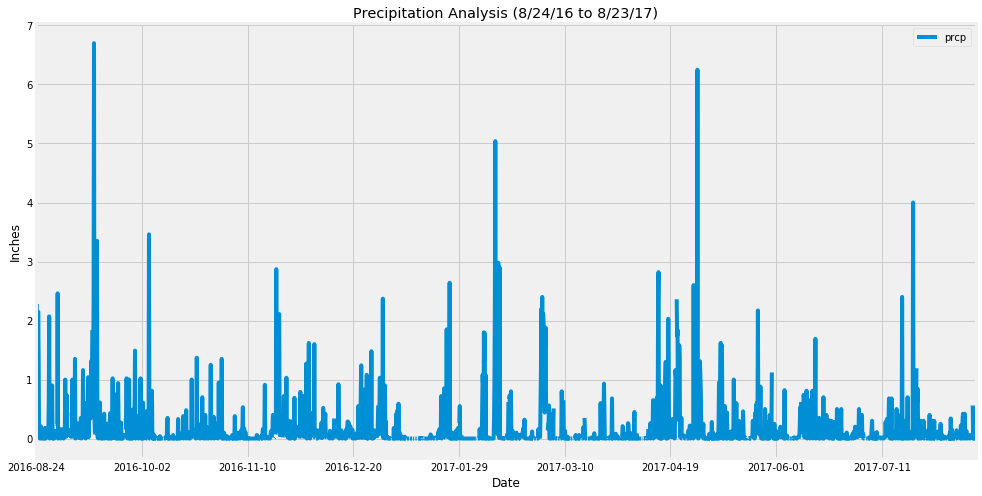

In [13]:
prec_plot= prec_df.plot(figsize=(15,8))
prec_plot.set_title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.ylabel("Inches")
plt.xlabel("Date")
plt.show()

In [14]:
# Get summary statistics for the precipitation data.
prec_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [15]:
# Amount of Station available
amount_stations = session.query(measurement).group_by(measurement.station).count()
print("There are {} stations available.".format(amount_stations))

There are 9 stations available.


In [16]:
# Find the active stations
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
            group_by(measurement.station).\
            order_by(func.count(measurement.station).desc()).all()

print("These are the list of active stations: \n\n", active_stations) 

These are the list of active stations: 

 [('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [17]:
# Station with the highest number of observations

most_active_station = session.query(measurement.station, 
                                    func.count(measurement.station)).\
                                    group_by(measurement.station).\
                                    order_by(func.count(measurement.station).desc()).first()[0]
print("The station with the highest number of observations is:", most_active_station)

The station with the highest number of observations is: USC00519281


In [18]:
# Designing a query to retrieve the last 12 months of temperature observation data (TOBS).

temp_twelve= session.query(measurement.tobs).filter(measurement.station==most_active_station).\
                                filter(measurement.date>=one_year_ago).all()
temp_twelve_df= pd.DataFrame(temp_twelve)
temp_twelve_df


,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


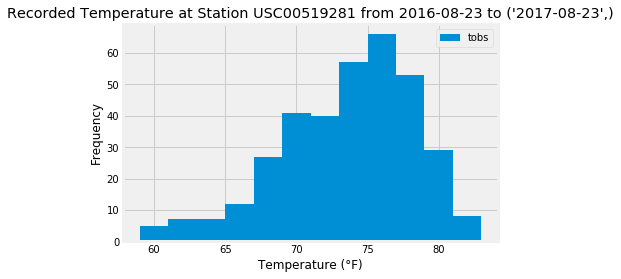

In [19]:
#create histogram
temperature = temp_twelve_df['tobs']
num_bins = 12
plt.hist(temperature, num_bins)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f"Recorded Temperature at Station {most_active_station} from {one_year_ago} to {last_date}")
plt.legend(["tobs"])
plt.show()

## Bonus: Other Anlyses

### Temperture Analysis
Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in June and December?

In [46]:
#Identify Average temp in June at all stations across all available years
query_june="06"

june_avg=session.query(func.avg(measurement.tobs), measurement.station).group_by(measurement.station).\
         filter(func.strftime("%m", measurement.date)== query_june).all()
for tobs, station in june_avg:
    print(f'The {station} station has an average temperture of {tobs}')

june_avg_1= session.query(func.avg(measurement.tobs)).group_by(measurement.station).\
         filter(func.strftime("%m", measurement.date)== query_june).all()

The USC00511918 station has an average temperture of 74.13939393939394
The USC00513117 station has an average temperture of 74.05084745762711
The USC00514830 station has an average temperture of 76.00537634408602
The USC00516128 station has an average temperture of 71.9372197309417
The USC00517948 station has an average temperture of 76.6554054054054
The USC00518838 station has an average temperture of 73.39473684210526
The USC00519281 station has an average temperture of 73.27118644067797
The USC00519397 station has an average temperture of 77.55932203389831
The USC00519523 station has an average temperture of 76.66810344827586


In [47]:
#Identify Average temp in December at all stations across all available years
query_december="12"

december_avg=session.query(func.avg(measurement.tobs), measurement.station).group_by(measurement.station).\
         filter(func.strftime("%m", measurement.date)== query_december).all()
for tobs, station in december_avg:
    print(f'The {station} station has an average temperture of {tobs}')
    
dec_avg_1= session.query(func.avg(measurement.tobs)).group_by(measurement.station).\
         filter(func.strftime("%m", measurement.date)== query_december).all()

The USC00511918 station has an average temperture of 69.6842105263158
The USC00513117 station has an average temperture of 71.06944444444444
The USC00514830 station has an average temperture of 73.2247191011236
The USC00516128 station has an average temperture of 69.29126213592232
The USC00517948 station has an average temperture of 71.8348623853211
The USC00518838 station has an average temperture of 72.42105263157895
The USC00519281 station has an average temperture of 69.90322580645162
The USC00519397 station has an average temperture of 71.10952380952381
The USC00519523 station has an average temperture of 72.43333333333334


In [57]:
# perform the t-test 
def ttest_compare(x,y, alpha):
    stat, p= ttest_ind(x,y)
    print("Statistics= %.3f, p= %.3f" %(stat,p))
    if p > alpha:
        print("Distribution shows that the two averages are different")
    else:
        print("Distribution shows that the two averages are similar")
        
ttest_compare(june_avg_1, dec_avg_1, 0.05)
# stats.ttest_ind(june_avg_1, dec_avg_1, equal_var=False)

Statistics= 4.616, p= 0.000
Distribution shows that the two averages are similar


### Temperature Analysis II

In [61]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-02-28', '2016-03-10'))
box_temp= (calc_temps('2016-02-28', '2016-03-10'))

[(62.0, 70.2051282051282, 80.0)]


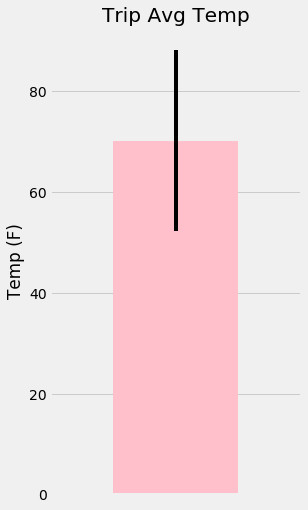

In [84]:
# create the dataframe
box_temp = pd.DataFrame(box_temp, columns=["t_min", "t_avg", "t_max"])

# plot the average temp 
plt.figure(figsize=(4,8))
ax=box_temp["t_avg"].plot.bar(yerr=(box_temp["t_max"]-box_temp["t_min"]), color="pink")
# plt.bar(0,box_temp["t_avg"], yerr=(box_temp["t_max"]-box_temp["t_min"]), color= "pink" )
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
ax.axes.get_xaxis().set_visible(False)
plt.show()


# # plotting the data as a boxplot

# # fig, ax = plt.subplots()
# # x = range(len(temp_avg_lst_year))
# plt.boxplot(box_temp, meanline=True)
# plt.title('Trip Avg Temp')
# plt.ylabel("Temp (F)")
# plt.xlabel("Trip")
# plt.show()




### Daily Rainfall Average

In [89]:
start_date= '2016-02-28'
end_date= '2017-03-10'


def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]